In [1]:
import os
import sys
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql.functions import from_json, col, regexp_replace, split, expr, from_unixtime, to_timestamp, from_utc_timestamp, date_format

In [2]:
#Declare environment
os.environ['SPARK_HOME'] = "C:/spark"
os.environ['HADOOP_HOME'] = "C:/hadoop"
os.environ['PATH'] = "C:/hadoop/bin"
os.environ["PYSPARK_PYTHON"] = sys.executable      
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [3]:
# Create Spark Session
spark = SparkSession.builder.appName("JupyterPySpark").getOrCreate()

In [4]:
df = spark.read.json("C:/Users/Kevin Mun/Downloads/archive/cc_sample_transaction.json")

In [5]:
##Show first 5 row of the data
df.show(5)

+----------+------+-------------+-----------+----------------+--------+----------------+----------------------+------------------+-----------+-------------+--------------------+--------------------+---------------------+--------------------+
|Unnamed: 0|   amt|     category|     cc_bic|          cc_num|is_fraud|  merch_eff_time|merch_last_update_time|         merch_lat| merch_long|merch_zipcode|            merchant|     personal_detail|trans_date_trans_time|           trans_num|
+----------+------+-------------+-----------+----------------+--------+----------------+----------------------+------------------+-----------+-------------+--------------------+--------------------+---------------------+--------------------+
|         0|  4.97|     misc_net|CITIUS33CHI|2703186189652095|       0|1325376018798532|         1325376018666|         36.011293| -82.048315|        28705|fraud_Rippin, Kub...|{"person_name":"J...|  2019-01-01 00:00:18|0b242abb623afc578...|
|         1|107.23|  grocery_pos

In [6]:
##Show data columns
df.columns

['Unnamed: 0',
 'amt',
 'category',
 'cc_bic',
 'cc_num',
 'is_fraud',
 'merch_eff_time',
 'merch_last_update_time',
 'merch_lat',
 'merch_long',
 'merch_zipcode',
 'merchant',
 'personal_detail',
 'trans_date_trans_time',
 'trans_num']

In [7]:
##based on raw data there are few columns are in nested json data
##Create a schema for nested json data
personal_detail_schema = StructType([
    StructField("person_name", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("address", StringType(), True),   # still a stringified JSON
    StructField("lat", StringType(), True),
    StructField("long", StringType(), True),
    StructField("city_pop", StringType(), True),
    StructField("job", StringType(), True),
    StructField("dob", StringType(), True)
])

address_schema = StructType([
    StructField("street", StringType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("zip", StringType(), True)
])

In [8]:
df_parsed = df.withColumn(
    "personal_detail_parsed",
    from_json(col("personal_detail"), personal_detail_schema)
)

In [9]:
df_final = df_parsed.withColumn(
    "address_parsed",
    from_json(col("personal_detail_parsed.address"), address_schema)
)

In [10]:
#Check on first 5 row extract from schema
df_final.select(
    col("personal_detail_parsed.person_name"),
    col("address_parsed.city"),
    col("address_parsed.state"),
    col("personal_detail_parsed.dob")
).show(5, False)

+--------------------+--------------+-----+----------+
|person_name         |city          |state|dob       |
+--------------------+--------------+-----+----------+
|Jennifer,Banks,eeeee|Moravian Falls|NC   |1988-03-09|
|Stephanie,Gill,eeeee|Orient        |WA   |1978-06-21|
|Edward@Sanchez      |Malad City    |ID   |1962-01-19|
|Jeremy/White, !     |Boulder       |MT   |1967-01-12|
|Tyler@Garcia        |Doe Hill      |VA   |1986-03-28|
+--------------------+--------------+-----+----------+
only showing top 5 rows


In [11]:
###From here, we notice person_name consist of unwanted symbol and random unwanted words.
##To keep it simple, we will first remove the unwanted symbol and space to comma. 

df_clean_name = df_final.withColumn(
    "clean_name", regexp_replace(col("personal_detail_parsed.person_name"), "[^a-zA-Z]", ",")
)

##After having the comma, we split into different level.
df_clean_name = df_clean_name.withColumn(
    "parts", split(col("clean_name"), ",")
)

##We will get the first two words appear in parts value. 
df_clean_name = df_clean_name.withColumn(
    "first",
    expr("filter(parts, x -> x != '')[0]")
).withColumn(
    "last",
    expr("filter(parts, x -> x != '')[1]")
)

In [12]:
df_clean_name.columns

['Unnamed: 0',
 'amt',
 'category',
 'cc_bic',
 'cc_num',
 'is_fraud',
 'merch_eff_time',
 'merch_last_update_time',
 'merch_lat',
 'merch_long',
 'merch_zipcode',
 'merchant',
 'personal_detail',
 'trans_date_trans_time',
 'trans_num',
 'personal_detail_parsed',
 'address_parsed',
 'clean_name',
 'parts',
 'first',
 'last']

In [13]:
df_clean_name.select(
    col("merch_eff_time"),
    col("merch_last_update_time"),
    col("trans_date_trans_time")).show(5)

+----------------+----------------------+---------------------+
|  merch_eff_time|merch_last_update_time|trans_date_trans_time|
+----------------+----------------------+---------------------+
|1325376018798532|         1325376018666|  2019-01-01 00:00:18|
|1325376044867960|          132537604479|  2019-01-01 00:00:44|
|1325376051506840|         1325376051286|  2019-01-01 00:00:51|
|1325376076794698|         1325376076365|  2019-01-01 00:01:16|
|1325376186746376|          132537618681|  2019-01-01 00:03:06|
+----------------+----------------------+---------------------+
only showing top 5 rows


In [14]:
##Based on raw data merch column is still in big integers which will need to 
##1. convert from microsecond to second 
df_clean_time = df_clean_name.withColumn("merch_eff_time_ts", (col("merch_eff_time") / 1_000_000).cast("double"))
df_clean_time = df_clean_time.withColumn("merch_last_update_time_ts", (col("merch_last_update_time") / 1_000_000).cast("double"))

##2. convert to human readable timestamp UTC+8
df_clean_time = df_clean_time.withColumn(
    "merch_eff_time",
    date_format(
        from_utc_timestamp(from_unixtime(col("merch_eff_time_ts")), "Asia/Singapore"),
        "yyyy-MM-dd HH:mm:ss.SSSSSS XXX"
    )
)

df_clean_time = df_clean_time.withColumn(
    "merch_last_update_time",
    date_format(
        from_utc_timestamp(from_unixtime(col("merch_last_update_time_ts")), "Asia/Singapore"),
        "yyyy-MM-dd HH:mm:ss.SSSSSS XXX"
    )
)

##for trans_date_trans_time column it is already in timestamp format so
##Convert string timestamp column
df_clean_time = df_clean_time.withColumn(
    "trans_date_trans_time",
    date_format(
        from_utc_timestamp(to_timestamp(col("trans_date_trans_time")), "Asia/Singapore"),
        "yyyy-MM-dd HH:mm:ss.SSSSSS XXX"
    )
)

In [15]:
#Final results select wanted columns
df_clean_time.select(
    col("Unnamed: 0"),
    col("trans_date_trans_time"),
    col("cc_num"),
    col("merchant"),
    col("category"),
    col("amt"),
    col("first"),
    col("last"),
    col("personal_detail_parsed.gender"),
    col("address_parsed.street"),
    col("address_parsed.city"),
    col("address_parsed.state"),
    col("address_parsed.zip"),
    col("personal_detail_parsed.lat"),
    col("personal_detail_parsed.long"),
    col("personal_detail_parsed.city_pop"),
    col("personal_detail_parsed.job"),
    col("personal_detail_parsed.dob"),
    col("trans_num"),
    col("merch_lat"),
    col("merch_long"),
    col("is_fraud"),
    col("merch_zipcode"),
    col("merch_last_update_time"),
    col("merch_eff_time"),
    col("cc_bic")
).show(10, False)

+----------+---------------------------------+----------------+----------------------------------+-------------+------+---------+--------+------+------------------------------+--------------+-----+-----+-------+------------------+--------+---------------------------------+----------+--------------------------------+------------------+------------------+--------+-------------+---------------------------------+---------------------------------+-----------+
|Unnamed: 0|trans_date_trans_time            |cc_num          |merchant                          |category     |amt   |first    |last    |gender|street                        |city          |state|zip  |lat    |long              |city_pop|job                              |dob       |trans_num                       |merch_lat         |merch_long        |is_fraud|merch_zipcode|merch_last_update_time           |merch_eff_time                   |cc_bic     |
+----------+---------------------------------+----------------+-------------------

In [16]:
final_df = df_clean_time.select(
    col("Unnamed: 0"),
    col("trans_date_trans_time"),
    col("cc_num"),
    col("merchant"),
    col("category"),
    col("amt"),
    col("first"),
    col("last"),
    col("personal_detail_parsed.gender"),
    col("address_parsed.street"),
    col("address_parsed.city"),
    col("address_parsed.state"),
    col("address_parsed.zip"),
    col("personal_detail_parsed.lat"),
    col("personal_detail_parsed.long"),
    col("personal_detail_parsed.city_pop"),
    col("personal_detail_parsed.job"),
    col("personal_detail_parsed.dob"),
    col("trans_num"),
    col("merch_lat"),
    col("merch_long"),
    col("is_fraud"),
    col("merch_zipcode"),
    col("merch_last_update_time"),
    col("merch_eff_time"),
    col("cc_bic")
)

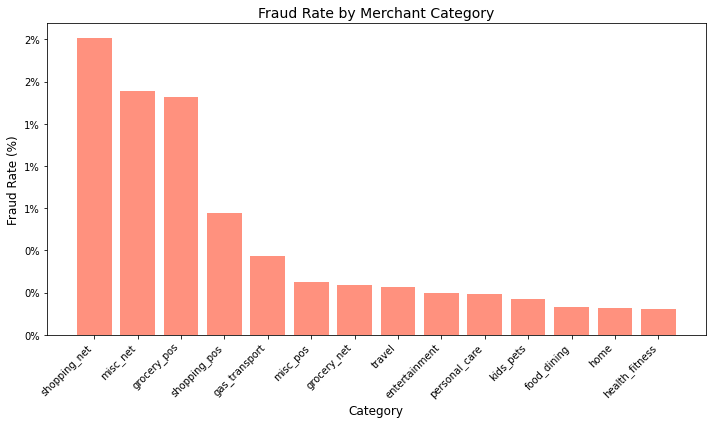

In [17]:
##SHOW IN GRAPH
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# --- 1. Fraud Rate by Category ---
fraud_by_cat = (
    final_df.groupBy("category")
      .agg(
          F.count("*").alias("total_txn"),
          F.sum("is_fraud").alias("fraud_txn"),
          (F.sum("is_fraud") / F.count("*")).alias("fraud_rate")
      )
      .orderBy(F.desc("fraud_rate"))
)

# Convert to Pandas for plotting
pdf = fraud_by_cat.toPandas()

# --- 2. Plot ---
plt.figure(figsize=(10, 6))
plt.bar(pdf["category"], pdf["fraud_rate"], color="tomato", alpha=0.7)

plt.title("Fraud Rate by Merchant Category", fontsize=14)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Fraud Rate (%)", fontsize=12)
plt.xticks(rotation=45, ha="right")

# Format Y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()